In [1]:
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as sqlF
from pyspark import SparkContext, SparkConf

In [2]:
from pyspark.ml.clustering import LDA, KMeans, DistributedLDAModel
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.feature import HashingTF, IDF, RegexTokenizer, NGram
from pyspark.ml import Pipeline

from pyspark.ml.feature import CountVectorizer

from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline

In [5]:
conf = SparkConf().setAll([('spark.executor.memory', '5g'), 
                           ('spark.driver.memory','5g'),
                           ('spark.driver.maxResultSize','0')])
                    #("spark.jars.packages", "JohnSnowLabs:spark-nlp:2.4.0")])
                    # questo pacchetto serve per NLP in spark

my_spark = SparkSession \
    .builder.master('local[*]') \
    .appName("ClusterApp")\
    .config(conf=conf)\
    .getOrCreate()

sqlContext = SQLContext(sparkContext=my_spark.sparkContext, 
                        sparkSession=my_spark)

In [6]:
schema = StructType([StructField("product", StringType(), False),
                 StructField("votes", IntegerType(), True),
                 StructField("rate", DoubleType(), True),
                 StructField("userID", StringType(), False),
                 StructField("original_text", StringType(), True),
                 StructField("text", StringType(), True),
                 StructField("summary", StringType(), True)])

csv_reader = sqlContext.read.\
                options(header='false', 
                inferschema='false',
                delimiter="\t").\
                schema(schema)

In [7]:
df = csv_reader.csv("hdfs://localhost:9000/TextMining/tokens/part-*").na.drop()

In [8]:
df.count()

5464515

In [10]:
hist = df.select("rate")\
         .groupBy("rate")\
         .count()\
         .toPandas()

In [17]:
hist["count_normalized"] = hist["count"]/sum(hist["count"])

In [34]:
hist = hist.sort_values("rate").reset_index().drop('index', axis=1)

hist

,rate,count,count_normalized
0,1.0,258294,0.047268
1,2.0,213119,0.039001
2,3.0,475678,0.087049
3,4.0,1197765,0.219190
4,5.0,3319659,0.607494


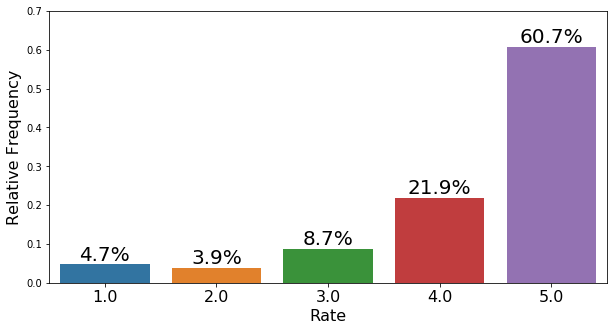

In [63]:
plt.figure(figsize=(10,5))
sns.barplot(x="rate", y="count_normalized", data=hist)

for index, row in hist.iterrows():
    plt.text(row.name,row.count_normalized + 0.01, str(round(row["count_normalized"]*100,1)) + "%", color='black', ha="center", size=20)

plt.ylabel("Relative Frequency", size=16)
plt.ylim((0, 0.7))
plt.xlabel("Rate", size=16)
plt.xticks(size=16)

plt.savefig("report/imgs/rate_dist.png")
plt.show()

In [56]:
df.select("summary","rate","votes")\
  .groupBy("summary")\
  .agg(sqlF.mean("rate"), 
       sqlF.stddev("rate"),
       sqlF.mean("votes"), 
       sqlF.count("summary"))\
  .orderBy(sqlF.desc("count(summary)"))\
  .show(100)

+--------------------+------------------+--------------------+------------------+--------------+
|             summary|         avg(rate)|   stddev_samp(rate)|        avg(votes)|count(summary)|
+--------------------+------------------+--------------------+------------------+--------------+
|          Five Stars| 4.999690033584435| 0.02595899673204438|1.0748753735948426|        351651|
|          Four Stars| 4.000785180180592|0.036501725483390694| 1.047421230906883|        109529|
|         Three Stars|3.0014877317641835| 0.06160290302887173| 1.068813145331409|         45035|
|            One Star| 1.010877745091332| 0.19630745112776773|1.4211192447150578|         29234|
|           Good read|  4.33580830239622|  0.6443431345569475|1.1683260209247384|         23704|
|          Great read| 4.786770428015564| 0.43685592471735185|1.2047608148317692|         21845|
|          Great book| 4.838728492271799|  0.4096785813256267|1.2277631962671334|         20574|
|           Two Stars|2.002005

In [11]:
summary_res = df.select("summary","rate","votes").groupBy("summary").agg(sqlF.mean("rate"),sqlF.mean("votes"), sqlF.count("summary")).orderBy(sqlF.desc("count(summary)")).toPandas()

In [13]:
summary_res[summary_res["count(summary)"]>10000][["summary","count(summary)"]]

,summary,count(summary)
0,Five Stars,351651
1,Four Stars,109529
2,Three Stars,45035
3,One Star,29234
4,Good read,23704
5,Great read,21845
6,Great book,20574
7,Two Stars,19449
8,Loved it!,16543
9,Loved it,15746


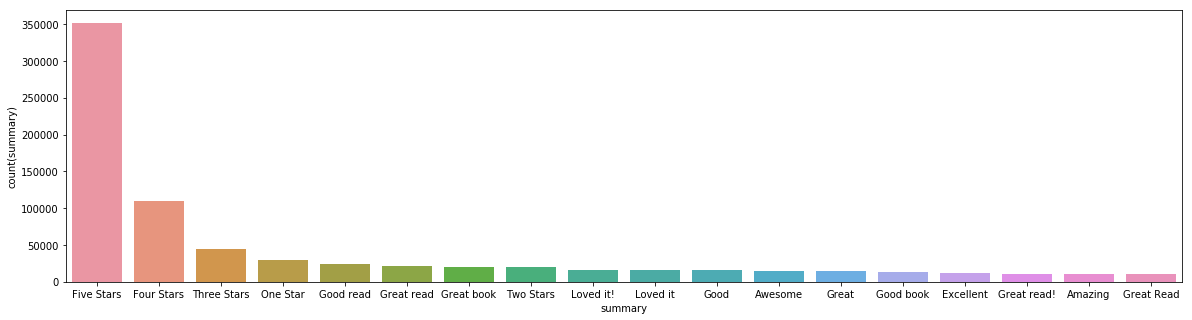

In [15]:
plt.figure(figsize=(20,5))
sns.barplot(x="summary", y="count(summary)", data=summary_res[summary_res["count(summary)"]>10000][["summary","count(summary)"]])
plt.show()

In [46]:
df.createTempView('data')

In [48]:
df.schema

StructType(List(StructField(product,StringType,true),StructField(votes,IntegerType,true),StructField(rate,DoubleType,true),StructField(original_text,StringType,true),StructField(text,StringType,true),StructField(summary,StringType,true)))

# Collaborative Filtering

In [8]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [9]:
temp_ = df.groupBy("userID")\
          .agg(sqlF.count("userID").alias("total"))\
          .sort(sqlF.desc("total"))\
          .filter("total > 20")

In [10]:
temp_.count()
# We have 25445 user with more than 20 products rated

25445

In [11]:
cf_data = df.select("userID","product","rate").join(temp_, "userID")

In [12]:
cf_data.count()

1425236

In [13]:
from pyspark.ml.feature import StringIndexer

indexer = [StringIndexer(inputCol=column, outputCol=column+"_index")\
           for column in ["userID", "product"] ]

In [14]:
#takes around 1 minute only
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(cf_data).transform(cf_data).select("userID_index","product_index","rate")
#transformed.show()

In [15]:
model = ALS(userCol="userID_index",
            itemCol="product_index",ratingCol="rate",
            coldStartStrategy="drop",nonnegative=True)\

pipeline = Pipeline(stages = [model])

paramGrid = ParamGridBuilder()\
  .addGrid(model.regParam, [0.05, 0.1])\
  .addGrid(model.maxIter, [10, 15])\
  .addGrid(model.rank, [5, 10, 20])\
  .build()

# do it with a cross validation on the train set (3 folds)
evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol="rate",
                                predictionCol="prediction")

cv = CrossValidator()\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)\
  .setEstimatorParamMaps(paramGrid)\
  .setNumFolds(3)

In [16]:
#each folds takes about fitting - 1-2 minute, evaluation - 1 minute
print("Training... ");
model = cv.fit(transformed)
print("done!")

Training... 
done!


In [31]:
print("lambda, num_iter, rank, score")
for i, metrics in enumerate(model.avgMetrics):
    print(list(model.getEstimatorParamMaps()[i].values()), metrics)

lambda, num_iter, rank, score
[0.05, 10, 5] 0.9045782873287344
[0.05, 10, 10] 0.9293972044012251
[0.05, 10, 20] 0.9378870768407066
[0.05, 15, 5] 0.8934316081766602
[0.05, 15, 10] 0.9093999187556485
[0.05, 15, 20] 0.9058310905556678
[0.1, 10, 5] 0.8317607564893841
[0.1, 10, 10] 0.8332038567694529
[0.1, 10, 20] 0.8286325628114417
[0.1, 15, 5] 0.8262674384581881
[0.1, 15, 10] 0.8242541905841678
[0.1, 15, 20] 0.8170563357501675


# Optimal k for clustering and n for n-grams finder

In [8]:
def get_pipeline(n, k, dist="euclidean", maxiter=20):
    "n=n-gram's n, k=number of clusters and dist={euclidean, cosine}"
    tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
    ngram = NGram(inputCol="words", outputCol="n-gram").setN(n)
    tf = CountVectorizer(inputCol="n-gram", outputCol="tf")
    idf = IDF(inputCol="tf", outputCol="features", minDocFreq=3)
    clus = KMeans().setSeed(123).setK(k).setDistanceMeasure(dist).setMaxIter(maxiter)


    pipeline = Pipeline(stages=[tokenizer, ngram, tf,idf, clus])
    return pipeline

In [17]:
all_res = dict()
best_silhouette = -1 #non può essere peggio
for n in range(1,4):
    k_mean_res = []
    for k in range(2,8):
        start_ = time.time()
        evaluator = ClusteringEvaluator()
        pipeline = get_pipeline(n,k)
        model = pipeline.fit(df)
        df2 = model.transform(df)
        silhouette = evaluator.evaluate(df2)
        k_mean_res.append(silhouette)
        if silhouette > best_silhouette:
            best_model = model
            best_silhouette = silhouette
        print("For n=", n, "and k=", k, "Silhouette = " + str(silhouette),
             "and took", str(round(time.time()-start_)), "s")
    all_res[n] = k_mean_res

For n= 1 and k= 2 Silhouette = 0.7818085663836597 and took 1158 s
For n= 1 and k= 3 Silhouette = 0.6267032164405654 and took 1143 s
For n= 1 and k= 4 Silhouette = 0.6266415172733281 and took 1154 s
For n= 1 and k= 5 Silhouette = 0.5795984101983523 and took 1159 s
For n= 1 and k= 6 Silhouette = 0.6238906185754778 and took 1179 s
For n= 1 and k= 7 Silhouette = 0.5672296785087502 and took 1176 s
For n= 2 and k= 2 Silhouette = 0.6367249295540462 and took 1010 s
For n= 2 and k= 3 Silhouette = 0.44214115115171454 and took 1012 s
For n= 2 and k= 4 Silhouette = 0.10317123265485793 and took 1017 s
For n= 2 and k= 5 Silhouette = 0.10319041989166616 and took 1026 s
For n= 2 and k= 6 Silhouette = 0.10564232146660846 and took 1035 s
For n= 2 and k= 7 Silhouette = 0.10631923033061005 and took 1051 s
For n= 3 and k= 2 Silhouette = 0.06653576342243957 and took 5091 s
For n= 3 and k= 3 Silhouette = 0.06806348935246632 and took 5046 s
For n= 3 and k= 4 Silhouette = 0.0678879417657483 and took 5085 s
For

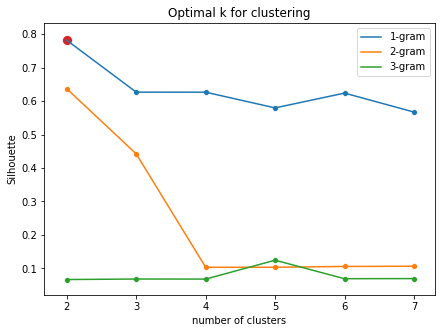

In [25]:
plt.figure(figsize=(7,5))
sns.lineplot(list(range(2,8)),all_res[1])
sns.scatterplot(list(range(2,8)),all_res[1])

sns.lineplot(list(range(2,8)),all_res[2])
sns.scatterplot(list(range(2,8)),all_res[2])

sns.lineplot(list(range(2,8)),all_res[3])
sns.scatterplot(list(range(2,8)),all_res[3])

sns.scatterplot(list(range(2,3)), all_res[1][0], s=100)

plt.xlabel('number of clusters')
plt.ylabel('Silhouette')
plt.title('Optimal k for clustering')
plt.xticks(list(range(2,8)))
plt.legend(["1-gram","2-gram","3-gram"])
plt.show()

In [9]:
#2 is the best, needed 10 minutes
evaluator = ClusteringEvaluator()
clus = get_pipeline(1,2,maxiter=100)#KMeans().setSeed(123).setK(2)
cluster_model = clus.fit(df)

In [10]:
df2 = cluster_model.transform(df)

In [11]:
df2.select('product','votes','rate','text','prediction').show()

+----------+-----+----+--------------------+----------+
|   product|votes|rate|                text|prediction|
+----------+-----+----+--------------------+----------+
|0143065971|    1| 5.0| great condit great |         0|
|0143065971|    4| 5.0|masterpiec someon...|         0|
|1423600150|    1| 5.0|great littl cookb...|         0|
|1423600150|    1| 5.0|   great mexi stuff |         0|
|1423600150|    1| 5.0|              great |         0|
|1423600150|    1| 5.0|excel sauc fun tr...|         0|
|1423600150|    1| 3.0|rather disappoint...|         0|
|1423600150|    1| 5.0|go favorit chef c...|         0|
|1423600150|    1| 5.0| uniqu delici salsa |         0|
|1423600150|    1| 5.0|  excel right topic |         0|
|1423600150|    1| 1.0|no color photo no...|         0|
|1423600150|    1| 5.0|veri good read hi...|         0|
|1423600150|    1| 4.0|mailman seem eith...|         0|
|1423600150|    1| 5.0|usual make salsa ...|         0|
|1423600150|    1| 1.0|recip good terrib...|    

In [12]:
df2.select('product','votes','rate','text','prediction')\
   .write.mode('overwrite')\
   .options(header='true')\
   .csv('hdfs://localhost:9000/TextMining/tokens/clustered')

In [13]:
df2.select("prediction").groupBy("prediction").count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|         1| 396720|
|         0|5067795|
+----------+-------+



In [14]:
assembler = VectorAssembler(inputCols=['votes','rate','prediction'], outputCol="corr_features")
corr_df = assembler.transform(df2)
pearsonCorr = Correlation.corr(corr_df, 'corr_features', 'pearson').collect()

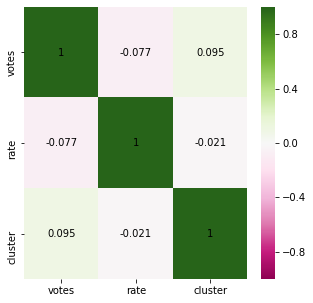

In [15]:
plt.figure(figsize=(5, 5))
sns.heatmap(pearsonCorr[0][0].values.reshape(3,3), 
            vmax=1, vmin=-1, annot=True,annot_kws={'color':'black'},
            xticklabels=['votes','rate','cluster'], 
            yticklabels=['votes','rate','cluster'], 
            center=0, cmap="PiYG")
plt.show()

In [16]:
df2.select(['rate','prediction']).groupBy('prediction').mean().show()

+----------+-----------------+---------------+
|prediction|        avg(rate)|avg(prediction)|
+----------+-----------------+---------------+
|         1|4.219686428715467|            1.0|
|         0|4.306979070779303|            0.0|
+----------+-----------------+---------------+



In [17]:
schema = StructType([StructField("product", StringType(), True),
                 StructField("votes", IntegerType(), True),
                 StructField("rate", DoubleType(), True),
                 StructField("text", StringType(), True),
                 StructField("cluster", IntegerType(), True)])

clus_df = sqlContext.read.\
                options(header='true', 
                inferschema='false',
                delimiter=",").\
                schema(schema).csv("hdfs://localhost:9000/TextMining/tokens/clustered/*")

In [18]:
text_0 = clus_df.filter("cluster==0").select("text")
text_1 = clus_df.filter("cluster==1").select("text")

In [19]:
res_0 = text_0.rdd.flatMap(lambda x: x[0].split(" "))\
                  .map(lambda word: (word, 1))\
                  .reduceByKey(lambda a, b: a + b)
res_1 = text_1.rdd.flatMap(lambda x: x[0].split(" "))\
                  .map(lambda word: (word, 1))\
                  .reduceByKey(lambda a, b: a + b)

In [20]:
schema = StructType([StructField("words", StringType(), True),
                 StructField("count", IntegerType(), True)])
res_df_0 = sqlContext.createDataFrame(res_0, schema=schema)
res_df_1 = sqlContext.createDataFrame(res_1, schema=schema)

In [21]:
res_df_0.groupBy().sum("count").show()

+----------+
|sum(count)|
+----------+
| 121830902|
+----------+



In [22]:
res_df_0.groupBy('words')\
        .agg(sqlF.mean("count")/121834908)\
        .orderBy(sqlF.desc("(avg(count) / 121834908)"))\
        .show(50)

+---------+------------------------+
|    words|(avg(count) / 121834908)|
+---------+------------------------+
|      not|    0.026157971080012634|
|    stori|    0.018424423975434034|
|     love|    0.015729900661967916|
|      one|    0.009537915028425187|
|    great|    0.009476651798349944|
|     like|    0.009368891221225365|
|     good|    0.009223522375048702|
|  charact|       0.008831081482821|
|     veri|    0.008295069258803888|
|     seri|    0.007995893919007187|
|    enjoy|    0.007584525774829657|
|     read|    0.006733595596427913|
|   realli|    0.006404913114064...|
|      get|    0.006207703624645902|
|     well|    0.005909570679037...|
|     time|    0.005519715252709018|
|      end|    0.005124311334482232|
|    money|    0.005116128129714679|
|     want|     0.00502716347928789|
|     make|     0.00427043454573791|
|    first|    0.004257654957149063|
|recommend|    0.004161705444879558|
|     look|    0.004022295482014071|
| interest|    0.003978646251368286|
|

In [23]:
res_df_1.groupBy().sum("count").show()

+----------+
|sum(count)|
+----------+
|  71097564|
+----------+



In [24]:
res_df_1.groupBy("words")\
        .agg(sqlF.mean("count")/71093558)\
        .orderBy(sqlF.desc("(avg(count) / 71093558)"))\
        .show(50)

+-------+-----------------------+
|  words|(avg(count) / 71093558)|
+-------+-----------------------+
|    not|   0.022786298021545075|
|  stori|    0.01111210385616092|
|   love|   0.009326372440102098|
|    one|   0.008907797243739017|
|   like|   0.007594991940057354|
|charact|    0.00648227508883435|
|    get|    0.00616941973842412|
|  money|   0.006132974804833934|
|   time|   0.005526056242676727|
|   want|   0.005159454813050713|
| realli|    0.00461822434038257|
|   make|   0.004449066960469189|
|   know|   0.004353643406059379|
|   life|   0.004224658442330...|
|  first|    0.00410338163128648|
|   veri|   0.004075193423291601|
|    way|   0.004067710326159...|
|     go|   0.003976506563365418|
|   seri|   0.003877524318026...|
|   well|   0.003827829238761...|
|     no|   0.003760031253464...|
|  thing|   0.003728931389254...|
|    end|   0.003698675483367987|
|   feel|   0.003654016022098655|
|   even|   0.003623324071078...|
|    see|   0.003618668234328629|
|   much|   0.

In [25]:
word_cloud_0 = res_df_0.orderBy(sqlF.desc("count"))\
                       .limit(200)\
                       .toPandas()\
                       .set_index('words')\
                       .T\
                       .to_dict('records')
word_cloud_1 = res_df_1.orderBy(sqlF.desc("count"))\
                       .limit(200)\
                       .toPandas()\
                       .set_index('words')\
                       .T\
                       .to_dict('records')

In [26]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np

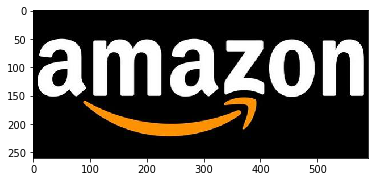

In [27]:
mask = np.array(Image.open("amazon.jpg"))

plt.imshow(mask, cmap="gray")
plt.show()

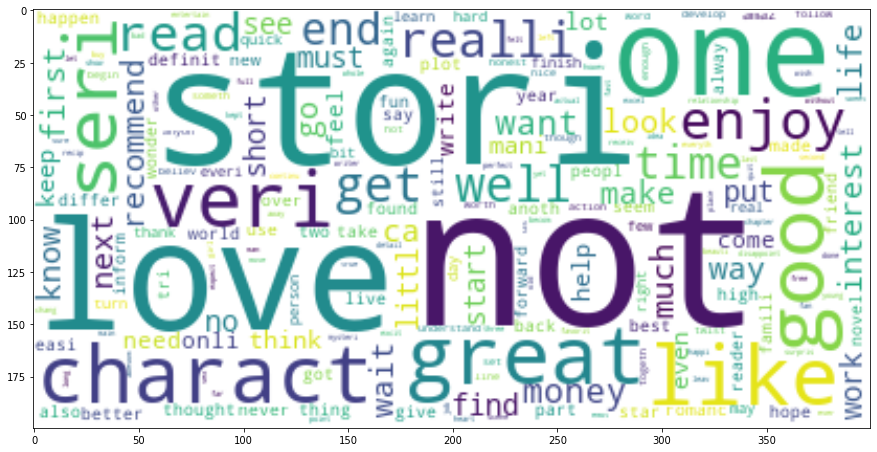

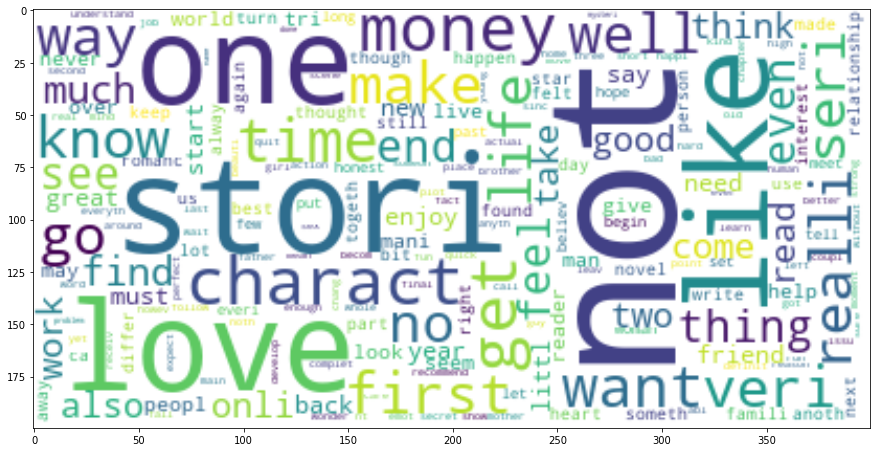

In [28]:
wc_0 = WordCloud(background_color="white", max_words=200)#, 
               #mask=mask, contour_color="black", contour_width=0)
wc_0.generate_from_frequencies(dict(*word_cloud_0))

wc_1 = WordCloud(background_color="white", max_words=200)#, 
               #mask=mask, contour_color="black", contour_width=0)
wc_1.generate_from_frequencies(dict(*word_cloud_1))

plt.figure(figsize=(15,10))
plt.imshow(wc_0, interpolation='bilinear')
plt.show()

plt.figure(figsize=(15,10))
plt.imshow(wc_1, interpolation='bilinear')
plt.show()

# Topic Modeling with LDA

In [34]:
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
ngram = NGram(n=1, inputCol="words", outputCol="n-gram")
tf = CountVectorizer(inputCol="n-gram", outputCol="tf")
idf = IDF(inputCol="tf", outputCol="features", minDocFreq=30)

pipeline = Pipeline(stages=[tokenizer, ngram, tf,idf])

pipe_mod = pipeline.fit(df)

df2 = pipe_mod.transform(df)

In [35]:
lda = LDA(k=10, maxIter=100)

In [36]:
model = lda.fit(df2) #took around 3.5 hours

In [66]:
vocab = pipe_mod.stages[-2].vocabulary

# Next, let's grab the topics generated by our LDA model via describeTopics(). Using collect(),
# we load the output into a Python array.
raw_topics = model.describeTopics().collect()

# Lastly, let's get the indices of the vocabulary terms from our topics
topic_inds = [ind.termIndices for ind in raw_topics]
topic_weights = [ind.termWeights for ind in raw_topics]

# The indices we just grab directly map to the term at position <ind> from our vocabulary. 
# Using the below code, we can generate the mappings from our topic indices to our vocabulary.
topics = dict()
for i, topic in enumerate(topic_inds):
    _topic = dict()
    for j, ind in enumerate(topic):
        _topic[vocab[ind]] = topic_weights[i][j]
        #_topic.append(vocab[ind] + ":" +  str(round(topic_weights[i][j],5)))
    topics["topic_"+str(i+1)] = _topic
    #topics.append(_topic)

# Let's see our topics!
#for i, topic in enumerate(topics, start=1):
#    print(f"topic {i}: {topic}")

In [79]:
for t in list(topics.keys()):
    display(pd.DataFrame(topics[t], index=[t]))

,love,not,want,get,one,feel,relationship,man,life,know
topic_1,0.004743,0.00453,0.003863,0.003788,0.003288,0.003237,0.003211,0.0031,0.003002,0.002981


,pictur,money,version,color,download,not,ship,print,free,use
topic_2,0.005167,0.004981,0.004785,0.0043,0.004101,0.003791,0.003555,0.003421,0.003115,0.003024


,love,hot,not,wait,ca,seri,sex,one,stori,sexi
topic_3,0.007487,0.00746,0.005574,0.004825,0.004582,0.004542,0.004517,0.004144,0.004111,0.004083


,life,god,children,help,love,us,kid,live,inspir,stori
topic_4,0.009246,0.006371,0.005753,0.005448,0.004944,0.004631,0.004392,0.004353,0.004225,0.004097


,town,murder,mate,find,friend,famili,mysteri,love,emma,bear
topic_5,0.003729,0.003471,0.003424,0.003349,0.003135,0.002907,0.002873,0.002637,0.002637,0.002618


,novel,world,money,stori,reader,charact,tale,fiction,time,one
topic_6,0.004491,0.003697,0.003545,0.003334,0.003261,0.003122,0.003044,0.002637,0.002427,0.002322


,recip,food,eat,diet,easi,inform,use,cook,weight,healthi
topic_7,0.017993,0.008341,0.007623,0.007257,0.006444,0.00633,0.006024,0.005285,0.005206,0.005075


,money,war,busi,use,histori,inform,peopl,understand,work,practic
topic_8,0.003548,0.00348,0.002906,0.00282,0.002654,0.002555,0.002527,0.002396,0.002328,0.00227


,seri,stori,charact,love,enjoy,not,great,next,read,end
topic_9,0.013772,0.013292,0.012145,0.011563,0.010028,0.009257,0.009152,0.008619,0.008377,0.008196


,not,money,like,good,no,time,get,edit,use,word
topic_10,0.009456,0.007815,0.006199,0.004856,0.00457,0.004495,0.00428,0.004194,0.004068,0.004053


In [67]:
import pandas as pd
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)
display(pd.DataFrame(topics))

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
love,0.004743,NaN,0.007487,0.004944,0.002637,NaN,NaN,NaN,0.011563,NaN
not,0.004530,0.003791,0.005574,NaN,NaN,NaN,NaN,NaN,0.009257,0.009456
want,0.003863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
get,0.003788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004280
one,0.003288,NaN,0.004144,NaN,NaN,0.002322,NaN,NaN,NaN,NaN
feel,0.003237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,0.003211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
man,0.003100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
life,0.003002,NaN,NaN,0.009246,NaN,NaN,NaN,NaN,NaN,NaN
know,0.002981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
# The indices we just grab directly map to the term at position <ind> from our vocabulary. 
# Using the below code, we can generate the mappings from our topic indices to our vocabulary.
topics = []
for i, topic in enumerate(topic_inds):
    _topic = []
    for j, ind in enumerate(topic):
        _topic.append(vocab[ind])
    topics.append(_topic)

# Let's see our topics!
for i, topic in enumerate(topics, start=1):
    print(f"topic {i}: {topic}")

topic 1: ['love', 'not', 'want', 'get', 'one', 'feel', 'relationship', 'man', 'life', 'know']
topic 2: ['pictur', 'money', 'version', 'color', 'download', 'not', 'ship', 'print', 'free', 'use']
topic 3: ['love', 'hot', 'not', 'wait', 'ca', 'seri', 'sex', 'one', 'stori', 'sexi']
topic 4: ['life', 'god', 'children', 'help', 'love', 'us', 'kid', 'live', 'inspir', 'stori']
topic 5: ['town', 'murder', 'mate', 'find', 'friend', 'famili', 'mysteri', 'love', 'emma', 'bear']
topic 6: ['novel', 'world', 'money', 'stori', 'reader', 'charact', 'tale', 'fiction', 'time', 'one']
topic 7: ['recip', 'food', 'eat', 'diet', 'easi', 'inform', 'use', 'cook', 'weight', 'healthi']
topic 8: ['money', 'war', 'busi', 'use', 'histori', 'inform', 'peopl', 'understand', 'work', 'practic']
topic 9: ['seri', 'stori', 'charact', 'love', 'enjoy', 'not', 'great', 'next', 'read', 'end']
topic 10: ['not', 'money', 'like', 'good', 'no', 'time', 'get', 'edit', 'use', 'word']


### results of when tried with k=20, and few iterations and was accepting idf just with more than 3 elements. Will not be used for the project 

In [14]:
#k=20

vocab = pipe_mod.stages[-2].vocabulary

# Next, let's grab the topics generated by our LDA model via describeTopics(). Using collect(),
# we load the output into a Python array.
raw_topics = model.describeTopics().collect()

# Lastly, let's get the indices of the vocabulary terms from our topics
topic_inds = [ind.termIndices for ind in raw_topics]

# The indices we just grab directly map to the term at position <ind> from our vocabulary. 
# Using the below code, we can generate the mappings from our topic indices to our vocabulary.
topics = []
for topic in topic_inds:
    _topic = []
    for ind in topic:
        _topic.append(vocab[ind])
    topics.append(_topic)

# Let's see our topics!
for i, topic in enumerate(topics, start=1):
    print(f"topic {i}: {topic}")

topic 1: ['chloe', 'brad', 'not', 'billi', 'gon', 'stori', 'na', 'great', 'one', 'interest']
topic 2: ['chris', 'quinn', 'stephani', 'riley', 'maddi', 'finn', 'eden', 'stori', 'love', 'not']
topic 3: ['stori', 'not', 'charact', 'enjoy', 'seri', 'good', 'end', 'love', 'veri', 'short']
topic 4: ['ok', 'jane', 'austen', 'stori', 'victoria', 'love', 'not', 'great', 'ha', 'tucker']
topic 5: ['love', 'not', 'stori', 'life', 'one', 'get', 'feel', 'want', 'heart', 'like']
topic 6: ['love', 'matt', 'not', 'stori', 'get', 'one', 'like', 'nathan', 'shade', 'grey']
topic 7: ['bear', 'seri', 'love', 'not', 'zombi', 'one', 'game', 'stori', 'find', 'like']
topic 8: ['not', 'fairi', 'stori', 'like', 'love', 'vampir', 'one', 'get', 'know', 'natali']
topic 9: ['love', 'not', 'want', 'seri', 'stori', 'one', 'get', 'wait', 'ca', 'see']
topic 10: ['seri', 'forward', 'enjoy', 'charact', 'love', 'look', 'entertain', 'read', 'stori', 'great']
topic 11: ['stori', 'christian', 'world', 'life', 'reader', 'well',

# Sentiment with TextBlob

In [8]:
df.show()

+----------+-----+----+--------------+--------------------+--------------------+--------------------+
|   product|votes|rate|        userID|       original_text|                text|             summary|
+----------+-----+----+--------------+--------------------+--------------------+--------------------+
|0143065971|    1| 5.0|A3JXKC2CMCA9MR|Great condition a...| great condit great |          Five Stars|
|0143065971|    4| 5.0| A18GG84RF7J2B|This is a masterp...|masterpiec someon...|Fantastic Book Ab...|
|1423600150|    1| 5.0|A2VCOE59QZ9967|Great little cook...|great littl cookb...|           Delicious|
|1423600150|    1| 5.0|A1DBZ3TCVMCQW2|   Great mexi stuff.|   great mexi stuff |          Five Stars|
|1423600150|    1| 5.0| AYXIWMJSXU3PW|          Great book|              great |          Five Stars|
|1423600150|    1| 5.0| A49HDU3KQHM2D|Excellent book on...|excel sauc fun tr...|           excellent|
|1423600150|    1| 3.0| AK1SD25BJ9R76|It is rather disa...|rather disappoint...|Ot

In [10]:
df = df.select("votes", "rate","original_text")

In [24]:
from textblob import TextBlob

def sentiment_analysis(text):
    score = TextBlob(text).sentiment.polarity
    #if score > 0.2:
    #    return 1.0
    #if score > -0.2:
    #    return 0.0
    #return -1.0
    return score

sentiment_udf = sqlF.udf(sentiment_analysis , FloatType())

In [25]:
df = df.withColumn("sentiment_score", sentiment_udf(df['original_text']))

In [26]:
df.show()

+-----+----+--------------------+---------------+
|votes|rate|       original_text|sentiment_score|
+-----+----+--------------------+---------------+
|    1| 5.0|Great condition a...|            0.9|
|    4| 5.0|This is a masterp...|     0.11708705|
|    1| 5.0|Great little cook...|       0.340625|
|    1| 5.0|   Great mexi stuff.|            0.8|
|    1| 5.0|          Great book|            0.8|
|    1| 5.0|Excellent book on...|           0.65|
|    1| 3.0|It is rather disa...|    0.036666665|
|    1| 5.0|Going to a favori...|            0.5|
|    1| 5.0|Some unique and d...|         0.6875|
|    1| 5.0|Excellent book ri...|     0.64285713|
|    1| 1.0|No color photos. ...|            0.0|
|    1| 5.0|VERY GOOD READING...|          0.542|
|    1| 4.0|The Mailman seeme...|            0.5|
|    1| 5.0|I usually make up...|      0.3810606|
|    1| 1.0|Recipes are good ...|    -0.20296296|
|    1| 5.0|For the salsa lov...|     0.21306819|
|    1| 5.0|Cannot recommend ...|         0.4625|


In [27]:
assembler = VectorAssembler(inputCols=['votes','rate','sentiment_score'], outputCol="corr_features")

corr_df = assembler.transform(df)
pearsonCorr = Correlation.corr(corr_df, 'corr_features', 'pearson').collect()

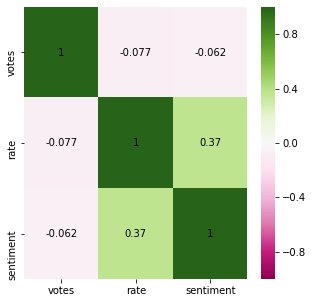

In [28]:
plt.figure(figsize=(5, 5))
sns.heatmap(pearsonCorr[0][0].values.reshape(3,3), 
            vmax=1, vmin=-1, annot=True,annot_kws={'color':'black'},
            xticklabels=['votes','rate','sentiment'], 
            yticklabels=['votes','rate','sentiment'], 
            center=0, cmap="PiYG")
plt.show()

In [29]:
df.select('votes','rate','sentiment_score').groupBy('rate').mean('votes','sentiment_score').orderBy("rate").show()

+----+------------------+--------------------+
|rate|        avg(votes)|avg(sentiment_score)|
+----+------------------+--------------------+
| 1.0| 3.360449720086413|-0.01608787075647...|
| 2.0|2.5255326836180725| 0.07715191396976337|
| 3.0| 1.738049689075383| 0.18952134854340555|
| 4.0|1.4178524167929436| 0.27724552303404415|
| 5.0|1.5618540940500214|  0.3349879993752049|
+----+------------------+--------------------+



# EXAM NOTEBOOK FINISHES HERE

# Embedding On spark, not for the exam
### just trying for fun, might be useful some day :D

In [110]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vector, Vectors, VectorUDT
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [8]:
document_assembler = DocumentAssembler()\
  .setInputCol("original_text")\
  .setOutputCol("document")\

tokenizer = Tokenizer().setInputCols(["document"])\
  .setOutputCol("token")

bert = BertEmbeddings.pretrained() \
 .setInputCols(["document","token"])\
 .setOutputCol("embeddings")\
 .setPoolingLayer(0)\
 .setCaseSensitive(False)


bert_pipeline = Pipeline().setStages(
    [document_assembler,tokenizer,bert])

df_bert = bert_pipeline.fit(df).transform(df)

bert_base_cased download started this may take some time.
Approximate size to download 389.2 MB
[OK!]


In [105]:
def avg_vectors(bert_vectors):
    length = len(bert_vectors[0]["embeddings"])
    avg_vec = [0] * length
    for vec in bert_vectors:
        for i, x in enumerate(vec["embeddings"]):
            avg_vec[i] += x
        avg_vec[i] = avg_vec[i] / length
    return avg_vec


#create the udf
avg_vectors_udf = sqlF.udf(avg_vectors, ArrayType(DoubleType()))
df_doc_vec = df_bert.withColumn("doc_vector", avg_vectors_udf(sqlF.col("embeddings")))
display(df_doc_vec)



def dense_vector(vec):
    return Vectors.dense(vec)

dense_vector_udf = sqlF.udf(dense_vector, VectorUDT())
training = df_doc_vec.withColumn("features", dense_vector_udf(sqlF.col("doc_vector")))

DataFrame[product: string, votes: int, rate: double, original_text: string, text: string, summary: string, document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, token: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, embeddings: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, doc_vector: array<double>]

In [116]:
binarizer = Binarizer()\
  .setInputCol("rate")\
  .setOutputCol("label")\
  .setThreshold(3.5)

# build the classifier
classifierMod = LogisticRegression()\
  .setMaxIter(10)\
  .setFeaturesCol("features")\
  .setLabelCol(binarizer.getOutputCol())

# this is the pipeline that data follows to be evaluated
pipeline = Pipeline(stages = [binarizer, classifierMod])

evaluator = MulticlassClassificationEvaluator(labelCol="label")

paramGrid = ParamGridBuilder()\
  .addGrid(classifierMod.regParam, [0.1])\
  .build()

cv = CrossValidator()\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)\
  .setEstimatorParamMaps(paramGrid)\
  .setNumFolds(3)

model = cv.fit(training)

In [32]:
my_spark.stop()